In [1]:
# Imports
import torch
import torchvision
from torchvision.datasets import MNIST

In [5]:
# Download training dataset
train_dataset = MNIST(root='data/', download=True)

In [6]:
len(train_dataset)

60000

In [7]:
#Download Test Dataset
test_dataset = MNIST(root='data/', train=False)

In [8]:
len(test_dataset)

10000

In [9]:
train_dataset[0]

(<PIL.Image.Image image mode=L size=28x28 at 0x1FCE0CE7670>, 5)

It's a pair, consisting of a 28x28px image and a label. The image is an object of the class PIL.Image.Image, which is a part of the Python imaging library Pillow. We can view the image within Jupyter using matplotlib, the de-facto plotting and graphing library for data science in Python.

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

Label: 5


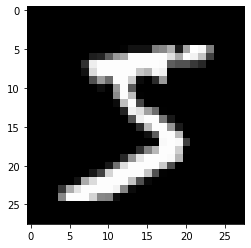

In [12]:
image, label = train_dataset[0]
plt.imshow(image, cmap='gray')
print('Label:', label)

Label: 4


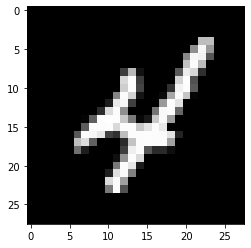

In [15]:
image, label = train_dataset[9]
plt.imshow(image, cmap='gray')
print('Label:', label)

It's evident that these images are relatively small in size, and recognizing the digits can sometimes be challenging even for the human eye. While it's useful to look at these images, there's just one problem here: PyTorch doesn't know how to work with images. We need to convert the images into tensors. We can do this by specifying a transform while creating our dataset.

In [16]:
import torchvision.transforms as transforms

PyTorch datasets allow us to specify one or more transformation functions that are applied to the images as they are loaded. The torchvision.transforms module contains many such predefined functions. We'll use the ToTensor transform to convert images into PyTorch tensors.

In [19]:
# MNIST dataset (images and labels)
train_dataset = MNIST(root='data/', 
                train=True,
                transform=transforms.ToTensor())

In [20]:
train_dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: data/
    Split: Train
    StandardTransform
Transform: ToTensor()

In [21]:
img_tensor, label = train_dataset[0]
print(img_tensor.shape, label)

torch.Size([1, 28, 28]) 5


The image is now converted to a 1x28x28 tensor. The first dimension tracks color channels. The second and third dimensions represent pixels along the height and width of the image, respectively. Since images in the MNIST dataset are grayscale, there's just one channel. Other datasets have images with color, in which case there are three channels: red, green, and blue (RGB).

In [22]:
print(img_tensor[0,10:15,10:15])
print(torch.max(img_tensor), torch.min(img_tensor))

tensor([[0.0039, 0.6039, 0.9922, 0.3529, 0.0000],
        [0.0000, 0.5451, 0.9922, 0.7451, 0.0078],
        [0.0000, 0.0431, 0.7451, 0.9922, 0.2745],
        [0.0000, 0.0000, 0.1373, 0.9451, 0.8824],
        [0.0000, 0.0000, 0.0000, 0.3176, 0.9412]])
tensor(1.) tensor(0.)


The values range from 0 to 1, with 0 representing black, 1 white, and the values in between different shades of grey. We can also plot the tensor as an image using plt.imshow

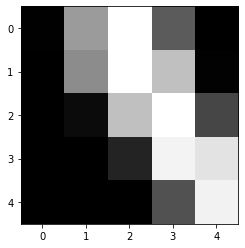

In [23]:
# Plot the image by passing in the 28x28 matrix
plt.imshow(img_tensor[0,10:15,10:15], cmap='gray');

#### Training and Validation Datasets
While building real-world machine learning models, it is quite common to split the dataset into three parts:

Training set - used to train the model, i.e., compute the loss and adjust the model's weights using gradient descent.
Validation set - used to evaluate the model during training, adjust hyperparameters (learning rate, etc.), and pick the best version of the model.
Test set - used to compare different models or approaches and report the model's final accuracy.
In the MNIST dataset, there are 60,000 training images and 10,000 test images. The test set is standardized so that different researchers can report their models' results against the same collection of images.

Since there's no predefined validation set, we must manually split the 60,000 images into training and validation datasets. Let's set aside 10,000 randomly chosen images for validation. We can do this using the random_spilt method from PyTorch.

In [24]:
from torch.utils.data import random_split

train_ds, val_ds = random_split(train_dataset, [50000, 10000])
len(train_ds), len(val_ds)

(50000, 10000)

It's essential to choose a random sample for creating a validation set. Training data is often sorted by the target labels, i.e., images of 0s, followed by 1s, followed by 2s, etc. If we create a validation set using the last 20% of images, it would only consist of 8s and 9s. In contrast, the training set would contain no 8s or 9s. Such a training-validation would make it impossible to train a useful model.

We can now create data loaders to help us load the data in batches. We'll use a batch size of 128.

In [25]:
from torch.utils.data import DataLoader

batch_size = 128

train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)

We set shuffle=True for the training data loader to ensure that the batches generated in each epoch are different. This randomization helps generalize & speed up the training process. On the other hand, since the validation data loader is used only for evaluating the model, there is no need to shuffle the images.

#### Model
Now that we have prepared our data loaders, we can define our model.

A logistic regression model is almost identical to a linear regression model. It contains weights and bias matrices, and the output is obtained using simple matrix operations (pred = x @ w.t() + b).

As we did with linear regression, we can use nn.Linear to create the model instead of manually creating and initializing the matrices.

Since nn.Linear expects each training example to be a vector, each 1x28x28 image tensor is flattened into a vector of size 784 (28*28) before being passed into the model.

The output for each image is a vector of size 10, with each element signifying the probability of a particular target label (i.e., 0 to 9). The predicted label for an image is simply the one with the highest probability.

In [26]:
import torch.nn as nn

input_size = 28*28
num_classes = 10

# Logistic regression model
model = nn.Linear(input_size, num_classes)

In [27]:
print(model.weight.shape)
model.weight

torch.Size([10, 784])


Parameter containing:
tensor([[-0.0150,  0.0335, -0.0134,  ...,  0.0326, -0.0200,  0.0016],
        [ 0.0014,  0.0326, -0.0219,  ..., -0.0024,  0.0207,  0.0139],
        [ 0.0297,  0.0124, -0.0021,  ..., -0.0291,  0.0285,  0.0036],
        ...,
        [ 0.0265, -0.0149,  0.0240,  ...,  0.0081,  0.0299, -0.0104],
        [ 0.0003, -0.0005,  0.0232,  ..., -0.0183, -0.0155, -0.0279],
        [-0.0288,  0.0257, -0.0301,  ..., -0.0104, -0.0072, -0.0053]],
       requires_grad=True)

In [28]:
print(model.bias.shape)
model.bias

torch.Size([10])


Parameter containing:
tensor([-0.0236,  0.0311, -0.0274,  0.0252,  0.0229, -0.0290, -0.0296, -0.0016,
         0.0237,  0.0091], requires_grad=True)

In [30]:
sum(p.numel() for p in model.parameters())

7850

Although there are a total of 7850 parameters here, conceptually, nothing has changed so far. Let's try and generate some outputs using our model. We'll take the first batch of 100 images from our dataset and pass them into our model.

In [31]:
for images, labels in train_loader:
    print(labels)
    print(images.shape)
    outputs = model(images)
    print(outputs)
    break

tensor([5, 5, 5, 6, 7, 8, 4, 7, 8, 4, 7, 4, 5, 2, 2, 0, 3, 5, 7, 4, 2, 0, 1, 6,
        4, 3, 5, 5, 6, 7, 6, 3, 5, 0, 3, 3, 4, 7, 8, 8, 3, 2, 2, 1, 2, 1, 3, 8,
        6, 8, 1, 9, 8, 4, 6, 8, 1, 0, 2, 0, 8, 9, 6, 4, 6, 7, 1, 0, 8, 7, 0, 8,
        3, 2, 5, 4, 5, 7, 8, 3, 8, 1, 4, 5, 9, 0, 6, 7, 1, 5, 5, 9, 3, 4, 2, 1,
        3, 1, 6, 4, 3, 7, 9, 7, 6, 9, 4, 3, 0, 3, 2, 0, 3, 5, 6, 1, 7, 8, 5, 3,
        5, 7, 1, 7, 0, 4, 1, 5])
torch.Size([128, 1, 28, 28])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (3584x28 and 784x10)

In [32]:
# Flattening the Vector
images.reshape(128, 784).shape

torch.Size([128, 784])

The code above leads to an error because our input data does not have the right shape. Our images are of the shape 1x28x28, but we need them to be vectors of size 784, i.e., we need to flatten them. We'll use the .reshape method of a tensor, which will allow us to efficiently 'view' each image as a flat vector without really creating a copy of the underlying data. To include this additional functionality within our model, we need to define a custom model by extending the nn.Module class from PyTorch.

In [33]:
class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)
        
    def forward(self, xb):
        xb = xb.reshape(-1, 784)
        out = self.linear(xb)
        return out
    
model = MnistModel()

Inside the __init__ constructor method, we instantiate the weights and biases using nn.Linear. And inside the forward method, which is invoked when we pass a batch of inputs to the model, we flatten the input tensor and pass it into self.linear.

xb.reshape(-1, 28*28) indicates to PyTorch that we want a view of the xb tensor with two dimensions. The length along the 2nd dimension is 28*28 (i.e., 784). One argument to .reshape can be set to -1 (in this case, the first dimension) to let PyTorch figure it out automatically based on the shape of the original tensor.

Note that the model no longer has .weight and .bias attributes (as they are now inside the .linear attribute), but it does have a .parameters method that returns a list containing the weights and bias.

In [34]:
model.linear

Linear(in_features=784, out_features=10, bias=True)

In [35]:
print(model.linear.weight.shape, model.linear.bias.shape)
list(model.parameters())

torch.Size([10, 784]) torch.Size([10])


[Parameter containing:
 tensor([[-0.0303,  0.0126, -0.0025,  ...,  0.0110,  0.0302,  0.0252],
         [ 0.0314, -0.0313,  0.0292,  ...,  0.0175, -0.0238, -0.0328],
         [-0.0059, -0.0164, -0.0296,  ..., -0.0301, -0.0353,  0.0274],
         ...,
         [ 0.0220, -0.0099, -0.0089,  ...,  0.0224,  0.0334,  0.0018],
         [-0.0160,  0.0284,  0.0339,  ...,  0.0330,  0.0181,  0.0173],
         [-0.0235,  0.0154,  0.0121,  ..., -0.0153,  0.0036,  0.0008]],
        requires_grad=True),
 Parameter containing:
 tensor([-0.0341, -0.0318, -0.0248,  0.0013,  0.0205,  0.0312,  0.0093, -0.0353,
         -0.0049,  0.0113], requires_grad=True)]

In [36]:
for images, labels in train_loader:
    print(images.shape)
    outputs = model(images)
    break

print('outputs.shape : ', outputs.shape)
print('Sample outputs :\n', outputs[:2].data)

torch.Size([128, 1, 28, 28])
outputs.shape :  torch.Size([128, 10])
Sample outputs :
 tensor([[-0.0657,  0.0481, -0.0480, -0.0994,  0.0602,  0.3727,  0.0757,  0.0343,
          0.0603,  0.0283],
        [-0.0707,  0.0289, -0.0351, -0.2526,  0.0136,  0.3238,  0.1319, -0.0736,
          0.0666,  0.2871]])


For each of the 100 input images, we get 10 outputs, one for each class. As discussed earlier, we'd like these outputs to represent probabilities. Each output row's elements must lie between 0 to 1 and add up to 1, which is not the case.

To convert the output rows into probabilities, we use the softmax function, which has the following formula:

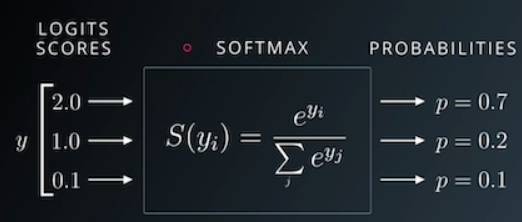

First, we replace each element yi in an output row by e^yi, making all the elements positive.


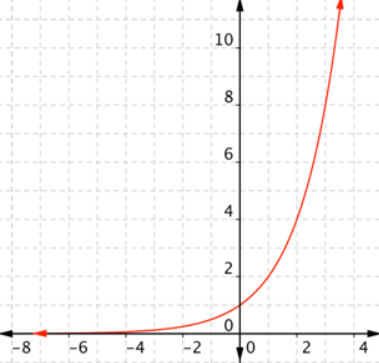

Then, we divide them by their sum to ensure that they add up to 1. The resulting vector can thus be interpreted as probabilities.


While it's easy to implement the softmax function, we'll use the implementation that's provided within PyTorch because it works well with multidimensional tensors (a list of output rows in our case).

In [38]:
import torch.nn.functional as F

In [40]:
#Apply softmax for each output row
probs = F.softmax(outputs, dim=1)

# Look at sample probabilities
print("Sample probabilities:\n", probs[:2].data)

# Add up the probabilities of an output row
print("Sum: ", torch.sum(probs[0]).item())

Sample probabilities:
 tensor([[0.0887, 0.0993, 0.0902, 0.0857, 0.1006, 0.1374, 0.1021, 0.0980, 0.1006,
         0.0974],
        [0.0881, 0.0974, 0.0913, 0.0735, 0.0959, 0.1308, 0.1079, 0.0879, 0.1011,
         0.1261]])
Sum:  1.0000001192092896


Finally, we can determine the predicted label for each image by simply choosing the index of the element with the highest probability in each output row. We can do this using torch.max, which returns each row's largest element and the corresponding index.

In [41]:
max_probs, preds = torch.max(probs, dim=1)
print(preds)
print(max_probs)

tensor([5, 5, 5, 5, 4, 4, 4, 0, 4, 9, 5, 6, 5, 4, 9, 5, 1, 4, 3, 5, 5, 9, 4, 4,
        9, 4, 3, 5, 5, 9, 5, 4, 8, 4, 9, 5, 5, 9, 2, 0, 9, 4, 5, 9, 5, 5, 9, 5,
        4, 5, 5, 5, 1, 5, 5, 6, 5, 5, 5, 2, 3, 5, 6, 5, 0, 2, 5, 1, 5, 5, 5, 9,
        9, 5, 0, 4, 6, 9, 9, 9, 9, 9, 6, 5, 4, 6, 4, 5, 2, 5, 4, 5, 9, 4, 4, 0,
        0, 5, 5, 5, 5, 4, 1, 5, 0, 5, 7, 9, 4, 5, 5, 7, 1, 9, 5, 9, 9, 4, 9, 5,
        5, 4, 4, 3, 3, 5, 5, 4])
tensor([0.1374, 0.1308, 0.1167, 0.1369, 0.1366, 0.1400, 0.1397, 0.1233, 0.1547,
        0.1297, 0.1468, 0.1172, 0.1267, 0.1424, 0.1212, 0.1336, 0.1345, 0.1238,
        0.1211, 0.1180, 0.1214, 0.1263, 0.1146, 0.1369, 0.1253, 0.1353, 0.1233,
        0.1145, 0.1495, 0.1307, 0.1214, 0.1258, 0.1215, 0.1201, 0.1643, 0.1341,
        0.1415, 0.1805, 0.1189, 0.1198, 0.1283, 0.1379, 0.1302, 0.1354, 0.1407,
        0.1239, 0.1432, 0.1266, 0.1120, 0.1372, 0.1459, 0.1534, 0.1240, 0.1197,
        0.1231, 0.1165, 0.1233, 0.1191, 0.1328, 0.1314, 0.1386, 0.1319, 0.1331,
       

In [42]:
labels

tensor([3, 3, 4, 0, 0, 0, 6, 1, 2, 7, 6, 5, 8, 9, 7, 8, 8, 0, 2, 5, 6, 8, 7, 0,
        8, 6, 9, 6, 3, 2, 4, 2, 5, 4, 0, 9, 9, 0, 4, 2, 9, 0, 9, 9, 8, 3, 5, 2,
        4, 7, 1, 5, 2, 3, 7, 4, 4, 1, 8, 0, 2, 2, 6, 5, 9, 6, 8, 7, 7, 9, 7, 7,
        5, 8, 1, 4, 3, 0, 8, 0, 8, 3, 3, 5, 0, 3, 5, 6, 0, 7, 8, 8, 7, 9, 8, 7,
        1, 9, 6, 7, 6, 4, 7, 3, 1, 1, 9, 9, 6, 8, 3, 9, 6, 7, 1, 4, 3, 0, 4, 3,
        7, 1, 4, 9, 8, 1, 9, 0])